# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.shape

(7591, 2)

In [4]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


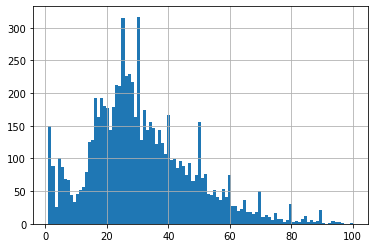

In [7]:
df['real_age'].hist(bins=100);

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


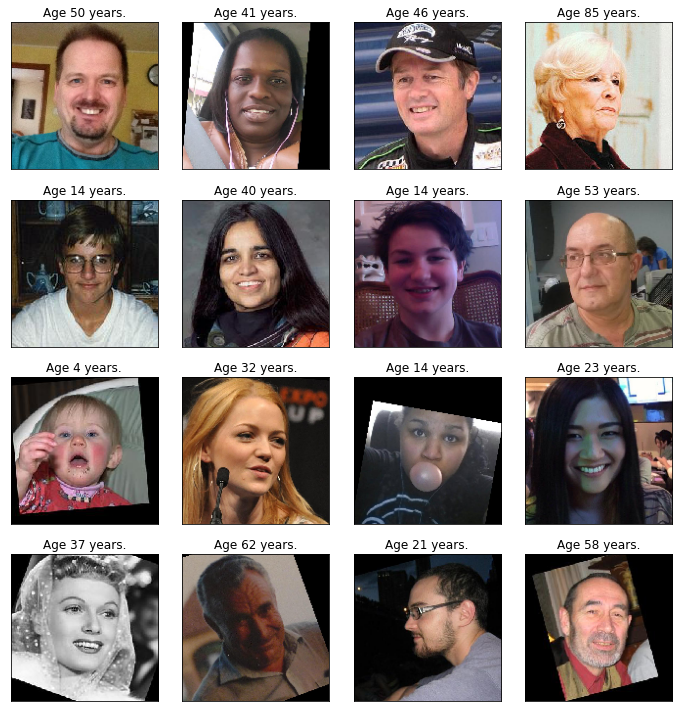

In [9]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age '+ str(target[i]) + ' years.')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Мы видим, что у нас нет картинок с возрастом 0 лет. Есть всплеск с картинками до 10 лет.

Средний возраст 31 год. А максимум 100 лет. Поэтому для возраста можно использовать другой тип данных — int8.

Визуально можно сказать, что целевой признак (возраст) соответствует изображениям.

В нашем наборе данных относительно мало лиц подростков и пожилых людей. Многие люди от 17 до 30 лет. Это может повлиять на точность распознавания разных возрастных групп. Лучше иметь больше данных.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

``` python
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

import pandas as pd


def load_train(path):

    df = pd.read_csv(path+'/labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255.,
                                       horizontal_flip=True,
                                       )

    train_data = datagen.flow_from_dataframe(
            dataframe=df,
            directory=path+'/final_files/',   
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345,
            subset='training')

    return train_data
    
    
def load_test(path):

    df = pd.read_csv(path+'/labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255.)

    test_data = datagen.flow_from_dataframe(
            dataframe=df,
            directory=path+'/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345,
            subset='validation')

    return test_data
    
    
def create_model(input_shape):   
    
    optimizer = Adam(0.0001) 
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model
    
    
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

## Анализ обученной модели

Мы провели предварительный анализ данных, посмотрели распределение.
Возможно, предсказание возраста в районе 10 лет и старше 80 лет будет не столь точным, так как людей с таким возрастом в нашей выборке довольно немного относительно всего набора данных.

Что помогло достичь целевого показателя:
- Adam 